# Development for pde-sim worker
Timothy Tyree<br>
4.1.2020

In [1]:
import sys, os, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.special import kn
from scipy.interpolate import BSpline
sys.path.append(os.path.abspath('../pde-sim-transfer/'))
from pde_sim_worker import *
from pde_sim_grid_scan import *
import test_cases
plt.rc('axes', linewidth=2)

# load the autoreload extension
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2


In [2]:
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
print('notebook is at: ' + nb_dir)

notebook is at: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/pde-sim/nb


## post process and collect data

## combine two dataframes stored as .csv's

In [32]:
def combine_df(fn1,fn2):
    df1 = pd.read_csv(fn1)
    df2 = pd.read_csv(fn2)
    out = pd.concat([df1,df2])
    print(df1.T.describe())
    print(df2.T.describe())
    print(out.T.describe())
    return out

In [33]:
save_fn = 'results_all.csv'
fn1 = 'results_run_4.csv'
fn2 = 'results_run_5_and_6.csv'
out = combine_df(fn1,fn2)
out = out.drop(columns=['Unnamed: 0', 'index']).copy()
out.astype('float32').reset_index().to_csv(save_fn, index_label='index')

           0          1          2          3          4          5      \
count  17.000000  17.000000  17.000000  17.000000  17.000000  17.000000   
mean    5.101254   5.367354   5.629797   5.888658   6.144874   6.400227   
std    10.219834  10.149543  10.101834  10.076120  10.071057  10.084576   
min    -0.555560  -0.555560  -0.552910  -0.547620  -0.541270  -0.534390   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000500   1.000000   2.000000   3.000000   4.000000   5.000000   
75%     6.558690   8.000000   8.000000   8.000000   8.000000   8.000000   
max    37.940000  37.940000  37.940000  37.940000  37.940000  37.940000   

           6          7          8          9      ...         63942  \
count  17.000000  17.000000  17.000000  17.000000  ...     17.000000   
mean    6.652411   6.901432   4.762298   4.983780  ...   3765.331110   
std    10.117391  10.168677   9.454240   9.455998  ...  15507.174048   
min    -0.527210  -0.520830  -0.6666

KeyboardInterrupt: 

In [47]:
boo = (out.mean_c<1000)
sum(boo)

206303

In [64]:
out.loc[~boo].astype('float32').head(300).describe()

,cycle_no,mean_c,mcd_at_100,mcd_at_200,mcd_at_300,mcd_at_400,mcd_at_500,mcd_at_800,kPDE,LPDE,c0,T,iter_no,dt,time_res
count,300.000000,1.300000e+02,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.0,300.000,300.0
mean,1.576667,inf,-0.700874,-0.678701,-0.661881,-0.651111,-0.642538,-0.612217,0.704046,383.263550,12.381667,16.663334,4.0,0.005,10.0
std,1.077649,NaN,0.238075,0.231318,0.227494,0.225626,0.222441,0.215024,0.326306,330.392761,17.297228,4.083164,0.0,0.000,0.0
min,0.000000,7.275109e+03,-0.989580,-0.979170,-0.979170,-0.972220,-0.965280,-0.947920,0.054570,26.360001,0.000000,12.000000,4.0,0.005,10.0
25%,1.000000,5.063047e+19,-0.917538,-0.890048,-0.866027,-0.861110,-0.842110,-0.814810,0.379200,78.500000,3.375000,12.000000,4.0,0.005,10.0
50%,2.000000,inf,-0.763890,-0.741900,-0.710070,-0.694440,-0.694440,-0.631305,0.807850,284.800003,6.000000,16.000000,4.0,0.005,10.0
75%,2.000000,inf,-0.506363,-0.495610,-0.471063,-0.459980,-0.457783,-0.444440,1.000000,695.000000,10.500000,19.000000,4.0,0.005,10.0
max,3.000000,inf,-0.171880,-0.171880,-0.171880,-0.170140,-0.168400,-0.069440,1.000000,1000.000000,70.000000,24.000000,4.0,0.005,10.0


In [65]:
# out.index.describe()
# out.head(10).dtypes=='float32'
out.loc[~boo].astype('float32').head(4)

,cycle_no,mean_c,mcd_at_100,mcd_at_200,mcd_at_300,mcd_at_400,mcd_at_500,mcd_at_800,kPDE,LPDE,c0,T,iter_no,dt,time_res
25,1.0,NaN,-0.61458,-0.61458,-0.61111,-0.60764,-0.60069,-0.58681,0.6157,695.000000,6.0,24.0,4.0,0.005,10.0
26,2.0,NaN,-0.40972,-0.40972,-0.40741,-0.40509,-0.40046,-0.39120,0.6157,695.000000,6.0,24.0,4.0,0.005,10.0
27,3.0,NaN,-0.30729,-0.30729,-0.30556,-0.30382,-0.30035,-0.29340,0.6157,695.000000,6.0,24.0,4.0,0.005,10.0
241,1.0,NaN,-0.52431,-0.51389,-0.50000,-0.49306,-0.48264,-0.46181,1.0000,112.900002,70.0,24.0,4.0,0.005,10.0


### (just do this in bash) condense an output folder into a single results 

In [27]:
# os.chdir(f'{nb_dir}/../data/')
# !(./condense_output.py -o Log/ -s results_run_5_and_6.csv)

#use this
# %run worker_pde_sim.py 1 2 3 4

## scratchwerk and old todo list

In [ ]:
#!/usr/bin/env python

# a humble worker for the PDE Simulation.
# Developer: Tim (the Tyrant) Tyree
# 3.31.2020


####TODO: (check )get worker wrapper that 
#TODO: iterates through a list of parameters listed in an input .txt file
# use dax-generator.py to do ^this
#TODO: makes a function that takes the output and brings it all into one nice file so data transfer doesn't take forever

####TODO(now) make task###
#TODO: copy example .py file from the osg's page, scalingup-python
#TODO: copy pde sim generator
#TODO: test cases

####TODO(later) adapt task### 
#TODO: compile to cython
#TODO: test cases
#TODO: make boolean function that measures the amount of time at a given distance had an outward cAMP gradient over 0.1/15 nM/µm from the cluster
#TODO: query ^that at 100-300 microns from the cluster. return true if long enough (whatever's consistent with old method)
#TODO: run ^that biatch on the open science grid with some parameter grid


## scratchwerk

In [ ]:
# sys.argv[0]
# !ls -1 */*
# source_fn = !ls *.csv
# source_fn = source_fn[0]

In [ ]:
# sys.argv

In [ ]:
# def foo(a):
#     print(sys.argv)
#     return True

In [ ]:
# foo(1)

In [ ]:
# from worker_pde_sim import *
#DONE: get worker_pde_sim.py to compile
#DONE: get it to parse the right arguments 
#DONE: get it up and running!

In [ ]:
# import overseer_pde_sim as ops
# df = ops.grid_to_df(c0grid = [1,2,3,4], kgrid=[0.0002,2])
# df.head()

In [ ]:
# #make argument DataFrame, store as csv.  load values and iterate through
# column_names = ['itno','kPDE','T','LPDE','c0','tr']
# default_values = [[3], [0.], [21], [100], [4], [10]]
# pd.DataFrame(dict(zip(column_names,default_values)))

### don't do this later: make the simulate function a little faster

In [ ]:
#TODO: copy here and test the simulate function 
#TODO: time the test function
#after compiling with cython
#after replacing the time step with matrix multiplication
#comment out the print statements

In [ ]:
# LPDE = 100
# kPDE = 0.02
# c0   = 4
# T    = 12
# itno = 1
# time_res = 10
# Ts      = T*60.#period of signal in seconds
# spl     = import_mg_source()
# # dsource = evaluate_mg_source(spl, t_list=None)
# # phi     = lambda t: F0*dsource[np.around(t,4)]/rmesh[0]

# #cylindrical FEM with localized PDE decay
# # define b.c.'s in units of slope #concentration difference per time step
# fluxLeft = lambda t:phi(t%Ts)
# fluxRight= 0./rmesh[-1]

# #save every time_res seconds
# step_num = int(time_res/dt)
# svetimes_init = np.arange(0,itno*Ts,dt)[::step_num] 
# svetimes = svetimes_init#savetimes in units of seconds
# tmin = 0.
# tmax = svetimes[-1] + dt

# #create camp field and initialize values
# c = c0+0.*rmesh
# pde = kn(0,rmesh/LPDE)/kn(0,r0/LPDE)#constitutive pde production in 2D radial coords
# c = c.astype('float64')
# pde = pde.astype('float64')
# #     pde = np.exp(-(rmesh-r0)/LPDE)#constitutive pde production in 1D coords
# #     pde = 1+0.*rmesh#uniform degradation

# # numerically integrate with forward euler integration
# sved = []
# Time = tmin

# #initialize
# #  make the mesh
# r0   = 50. #um
# Lr   = 1000.#um
# dr   = 1.  #um
# dt   = 0.0005#sec 
# rmesh    = np.arange(r0,Lr+dr,dr)
# # c = 0.*rmesh
# # pde = kn(0,rmesh/LPDE)/kn(0,r0/LPDE)
# #  define parameters
# D     = 100.#um^2/s
# F0    = 10**4
# inv_rmesh = 1./rmesh

# # def time_step(c, pde, rmesh, D, kPDE, dr, dt):
# #     #step one: update exterior faces and other state variables 
# # #     cp    = np.hstack([c[0]-dface[0], c, c[-1]+dface[-1]])
# #     dface = np.hstack([ 0. , np.diff(c) , 0. ])
# # #     face  = c[1:]*0.5 + c[:-1]*0.5
# #     cp    = np.hstack([c[0], c, c[-1]])
# #     face  = cp[1:]*0.5 + cp[:-1]*0.5

# #     #step two: calculate transient term
# #     term1 = D*np.multiply(np.diff(face),inv_rmesh)/dr
# # #     term1 = D*np.diff(face)/rmesh/dr
# #     term2 = D*np.diff(dface)/dr**2
# #     termDEG = -1*kPDE*np.multiply(c,pde)

# #     #add flux term
# #     termBC = np.hstack([ fluxLeft(Time) , 0*c[1:-1] , fluxRight ])

# #     #step three: integrate in time
# #     dcdt  = term1 + term2 + termBC + termDEG
# #     return c + dt*dcdt

In [ ]:
# #Stop wasting time on unnecessary opotimization!
# # import numpy as np
# # cimport numpy as np
# # def myfunc(np.ndarray[np.float64_t, ndim=2] A):
# # <...>

# start = time.time() 
# retval = time_step(c+1, pde, rmesh, D, kPDE, dr, dt)
# end = time.time()
# print('\n%s seconds elapsed numerically integrating.' % np.around(end-start,6))

### dev for recording cell direction 

In [ ]:
# #get whether or not the outward cAMP gradients are greater than some threshold value for greater than some threshold time for a wide range of parameter values.  
# def measure_at(c,loc, dr=1, thresh = (0.1/15)):
#     '''returns 1, 0, -1 if cells would be moving away, neither, or towards the cell cluster, respectively.'''
#     dface = np.hstack([ 0. , np.diff(c) , 0. ])##
#     return sign_w_thresh(dface[loc], thresh = thresh)
# def sign_w_thresh(arg,thresh):
#     '''returns 1 if arg is more than thresh, -1 if arg is less than -thresh, and zero else.
#     assumes thresh>0. See test cases for example usage.'''
#     if arg-thresh>0:
#         return 1
#     elif arg+thresh<0:
#         return -1
#     else:
#         return 0

In [ ]:
# #initialize loop invariants
# cycle_no = 0
# time = 0.
# r_bins = [100./dr,200./dr,300./dr]
# v_bucket = [[] for r in r_bins]
# dr = 1
# ds = 0.1/15

# #TODO: put the following in my simulate() when it works!

# #calculate direction of cell motion for each bin
# v_bins = [measure_at(c,int(r),dr=dr, thresh=ds) for r in r_bins]
# #record cell direction
# for i,l in enumerate(v_bucket):
#     l.append(v_bins[i])
# #     l.append(l)
# #     assert(v_bucket[0][1][1][1][1][1][1]==v_bucket[0])
# #^dude, I made a recursively defined list.
# # for l in v_bucket:
# #     for i,r in enumerate(r_bins):
# #         l.append(v_bins[i])

In [ ]:
# dface = np.hstack([ 0. , np.diff(c) , 0. ])##
# sign_w_thresh(dface[loc], thresh = ds)

In [ ]:
# v_bucket

In [ ]:
# v_bucket = [[0,12,3,4,5,6], [0,2,3,4], [0]]

# #calculate average cell motion for each bin
# v_mean = [sum(v)/len(v) for v in v_bucket]

# larger time step (dt=0.005 sec) is valid 

In [6]:
# %%time
# retval  = simulate(kPDE=0.02, 
#          LPDE=100, 
#          c0=10, T=10, 
#          iter_no=4, dt=0.0005, time_res=10)

Printing Inputs:
kPDE:0.02 LPDE:100 c0:10 T:10 iter_no:4 dt:0.0005 time_res:10

Printing Outputs including mean cell direction (mcd):
cycle_no,mean_c,mcd_at_100,mcd_at_200,mcd_at_300,mcd_at_400
0,9.55825,0.06667,0.11667,0.03333,0.11667
1,9.26838,0.05000,0.13333,0.07500,0.20833
2,9.01633,0.04444,0.12778,0.08889,0.22778
3,8.78876,0.04167,0.12083,0.09167,0.22500
CPU times: user 5min 56s, sys: 455 ms, total: 5min 57s
Wall time: 5min 57s


In [7]:
# # %%time
# retval  = simulate(kPDE=0.02, 
#          LPDE=100, 
#          c0=10, T=10, 
#          iter_no=4, dt=0.005, time_res=10)

Printing Inputs:
kPDE:0.02 LPDE:100 c0:10 T:10 iter_no:4 dt:0.005 time_res:10

Printing Outputs including mean cell direction (mcd):
cycle_no,mean_c,mcd_at_100,mcd_at_200,mcd_at_300,mcd_at_400,mcd_at_500,mcd_at_800
0,9.55823,0.06667,0.11667,0.03333,0.11667,0.00000,0.00000
1,9.26836,0.05000,0.13333,0.07500,0.20833,0.00000,0.00000
2,9.01630,0.04444,0.12778,0.08889,0.22778,0.00000,0.00000
3,8.78873,0.04167,0.12083,0.09167,0.22500,0.00000,0.00000


In [11]:
retval
#2:20 min for FEM original dt = 0.0005
#4:20 for implicit euler at 1 iteration dt = 0.0005
#0:28 for implicit euler at 1 iteration dt = 0.005

True

In [ ]:
retval  = simulate(kPDE=0.02, 
         LPDE=100, 
         c0=10, T=10, 
         iter_no=4, dt=0.005, time_res=10)

In [ ]:
c = retval-c_FEM
rmesh = np.arange(50,1001,1)
plt.scatter(x=rmesh,y=c)
plt.xlabel('r (µm)')
plt.ylabel('cAMP difference (nM)')
plt.title('2 iterations implicit euler method')
# plt.savefig('FEM.png')

In [ ]:

# c_FEM = retval
# rmesh = np.arange(50,1001,1)
# plt.scatter(x=rmesh,y=c_FEM)
# plt.xlabel('r (µm)')
# plt.ylabel('cAMP (nM)')
# plt.title('forward euler method')
# # plt.savefig('FEM.png')

# playing with cython to speed up the time_step
4.7.2020 - I gave this an hour, got a cython time_step compiling, and it doesn't save any time.  I probably need to do a highly technical alteration to make it faster unless I parallelize.

In [ ]:
import pyximport; pyximport.install()
from time_step import time_step as ts
from worker_pde_sim import time_step as ts2

In [ ]:
ca = c.astype('float32')
cb = pde.astype('float32')
cc = rmesh.astype('float32')

In [ ]:
%%time
retval = ts(ca,cb,cc, D, kPDE, dr, 0)

In [ ]:
%%time
retval = ts2(ca,cb,cc, D, kPDE, dr, 0)

# time step of dt=0.005 is accurate using forward euler integration

In [ ]:
%%time
retval  = simulate(kPDE=0.0002,
         LPDE=100,
         c0=4, T=21,
         iter_no=6, dt=0.005, time_res=10)

In [ ]:
%%time
retval  = simulate(kPDE=0.02,
         LPDE=100,
         c0=4, T=21,
         iter_no=6, dt=0.005, time_res=10)

In [ ]:
%%time
retval  = simulate(kPDE=0.0002,
         LPDE=100,
         c0=4, T=21,
         iter_no=3, dt=0.01, time_res=10)

In [ ]:
%%time
retval  = simulate(kPDE=0.0002,
         LPDE=100,
         c0=4, T=21,
         iter_no=3, dt=0.05, time_res=10)

In [ ]:
%%time
retval  = simulate(kPDE=0.0002,
         LPDE=100,
         c0=4, T=21,
         iter_no=3, dt=.1, time_res=10)

Printing Inputs:<br>
{kPDE:0.02,LPDE:100,c0:10,T:15,iter_no:1,dt:0.0005,time_res:10}<br>
<br>
Printing Outputs:<br>
cycle_no, 100.0, 200.0, 300.0<br>
0,-0.9888888888888889,0.0,0.0<br>
CPU times: user 2min 37s, sys: 710 ms, total: 2min 38s<br>
Wall time: 2min 39s<br>


### scratcwerk

In [34]:
#TEMPLATE:ScalingUp-PythonCals.submit

executable = ../scalingup-python-wrapper.sh
arguments = $(kPDE) $(LPDE) $(c0) $(T) $(iter_no), $(dt) $(time_res)

transfer_input_files = ../rosen_brock_brute_opt.py
 
output = Log/job.out.$(Cluster).$(Process)
error = Log/job.error.$(Cluster).$(Process)
log = Log/job.log.$(Cluster).$(Process)
   
request_cpus = 1
request_memory = 1 GB
request_disk = 1 GB
Requirements = OSGVO_OS_STRING == "RHEL 6" && TARGET.Arch == "X86_64" && HAS_MODULES == True 

on_exit_hold = (ExitBySignal == True) || (ExitCode != 0)
PeriodicRelease = ( (CurrentTime - EnteredCurrentStatus) > 120 ) && (NumJobStarts < 5)


queue kPDE LPDE c0 T iter_no dt time_res from (
-9 9 -9 9 
-8 8 -8 8 
-7 7 -7 7 
-6 6 -6 6 
-5 5 -5 5 
-4 4 -4 4 
-3 3 -3 3 
-2 2 -2 2 
-1 1 -1 1 
)

SyntaxError: invalid syntax (<ipython-input-34-d490c5ee4da8>, line 3)

# visually test the mg_source
ERROR THROUGH OUT OSG OUTPUT DATA PRIOR TO 1PM 4.9.2020<br>
It appears that I was using inconsistant time units?
I'll need to rerun everything ASAP

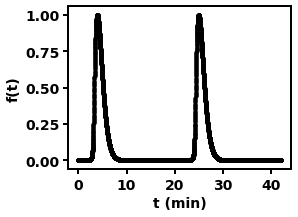

In [5]:
#plot the source
period=21
spl = import_mg_source(period=period)
tv = np.arange(0,2*period,0.005)#min
yv = spl(tv*60)

fig, ax = plt.subplots(figsize = (4,3))
fontsize= 14
plt.scatter(x=tv, y=yv, s=10, c='k')#seconds as argument
#format plot
ax.set_xlabel('t (min)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('f(t)', fontsize=fontsize, fontweight='bold')   
# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.axis([0.0001, .7, 10, 1000])
#   make ticks bold
ax.tick_params(width=2, length=5, which='both')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
fig.savefig('../fig/mg_source_1987_T_21_sf.png')

In [ ]:
# t_list  = np.around(np.arange(0,Ts+dt,dt),4)
# spl     = import_mg_source()
# dsource = evaluate_mg_source(spl, t_list)
# phi     = lambda t: F0*dsource[np.around(t,4)]/rmesh[0]



In [23]:
print(f"total integrated f(t) for 1 pulse is {sum(yv)/2*0.005} minutes.")

total integrated f(t) for 1 pulse is 1.9979758062770858 minutes.


In [117]:
# mg_scaled_fn = source_fn
# nn   = 3 #order of B spline interpolation
# period = 21#minutes
# #updated
# def import_mg_source(mg_scaled_fn='mg_source_1987.csv', nn = 3, period=21, ):
#     df = pd.read_csv(mg_scaled_fn)
#     t_values = df.times.values
#     a_values = df.synth_rate.values
#     spl = BSpline(t_values, a_values, nn, extrapolate='True')
#     Dt= 0.0005#minutes
#     t_list = np.arange(0,11,Dt)#minutes
#     c_list = spl(t_list)
#     t_list_2 = np.arange(11,period+Dt,Dt)
#     c_list_2 = 0*t_list_2#append zeros so vector is of period duration
#     #assumption that spl(11)~1e-5 is sufficiently close to zero
#     t_list = np.concatenate([t_list,t_list_2])*60#seconds as argument
#     c_list = np.concatenate([c_list,c_list_2])
#     spl2   = BSpline(t_list, c_list, nn, extrapolate='periodic')
#     return spl2

# # c_list = evaluate_mg_source(foo, t_list)


In [80]:
#DONE: make spline function take time in units of seconds
#TODO: put source in pde_sim_worker.py, synch, and rerun the faster trial